In [1]:
# basic imports
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from PIL import Image

In [2]:
# prompts for image generation
prompt = "dog and cat, walking, bloom, high quality, very high resolution, colorful refraction, lens flare"
negative_prompt = "bad anatomy, bad hands, text, error, missing fingers, extra digit, extra tail, fewer digits,  multiple legs, malformation, close up"

In [3]:
## image generation param
num_inference_steps=50
guidance_scale=7.5
height=512
width=512

In [ ]:
# https://github.com/shimosan/diffusers.git
# branch: 20230420-get-internal-info
from diffusers import StableDiffusionPipeline

## choose one of the following devices
#device = "cpu"  # this is too slow
#device = "cuda"  # very fast, but needs GPU at linux/windows
device = "mps"  # M1/M2 chips at macos

#model_version = "runwayml/stable-diffusion-v1-5"
#model_version = "prompthero/openjourney"
model_version = "andite/anything-v4.0"
#model_version = "../models/stable-diffusion-v1-5"
#model_version = "../models/openjourney"
#model_version = "../models/anything-v4.0"

pipe  = StableDiffusionPipeline.from_pretrained(model_version)
pipe = pipe.to(device)

In [5]:
torch.manual_seed(234)
out = pipe(prompt=prompt, negative_prompt=negative_prompt, height=height, width=width,
           num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
           needs_intermediate=True, # get intermediate images
           needs_cross_attention=True # get cross attention weights
)

  0%|          | 0/50 [00:00<?, ?it/s]

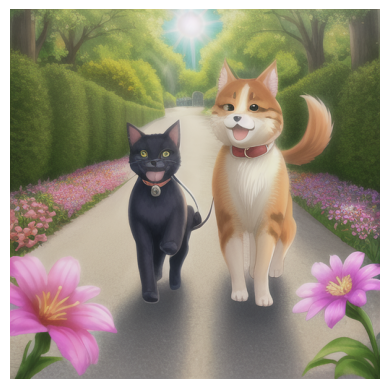

In [6]:
image = out['images'][0]
plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
# transformers imports
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# tokenize prompts
def text_tokenizer(prompt, ):
    prompt_token = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    return prompt_token

In [8]:
prompt_token = text_tokenizer(prompt)

for i,x in enumerate(prompt_token.input_ids[0]):
    print(f"{i:2d} {x.numpy():6d}  {tokenizer.decode(x)}")

 0  49406  <|startoftext|>
 1   1929  dog
 2    537  and
 3   2368  cat
 4    267  ,
 5   3941  walking
 6    267  ,
 7  10257  bloom
 8    267  ,
 9   1400  high
10   3027  quality
11    267  ,
12   1070  very
13   1400  high
14   9977  resolution
15    267  ,
16  11444  colorful
17    515  re
18  26788  fraction
19    267  ,
20   8666  lens
21  21185  flare
22  49407  <|endoftext|>
23  49407  <|endoftext|>
24  49407  <|endoftext|>
25  49407  <|endoftext|>
26  49407  <|endoftext|>
27  49407  <|endoftext|>
28  49407  <|endoftext|>
29  49407  <|endoftext|>
30  49407  <|endoftext|>
31  49407  <|endoftext|>
32  49407  <|endoftext|>
33  49407  <|endoftext|>
34  49407  <|endoftext|>
35  49407  <|endoftext|>
36  49407  <|endoftext|>
37  49407  <|endoftext|>
38  49407  <|endoftext|>
39  49407  <|endoftext|>
40  49407  <|endoftext|>
41  49407  <|endoftext|>
42  49407  <|endoftext|>
43  49407  <|endoftext|>
44  49407  <|endoftext|>
45  49407  <|endoftext|>
46  49407  <|endoftext|>
47  49407  <|

In [9]:
def poolmax_attn(attns):
    if(isinstance(attns,list)):
        out = [poolmax_attn(x) for x in attns]
    else:
        out, _ = torch.max(attns, dim=1)
        out 
    return out

def poolave_attn(attns):
    if(isinstance(attns,list)):
        out = [poolave_attn(x) for x in attns]
    else:
        out = torch.mean(attns, dim=1)
    return out

def imgattn(attn):
    size = int(np.sqrt(attn.shape[1]))
    attn = attn.reshape(attn.shape[0], size, size, -1)
    return attn.detach().cpu().numpy()

def showattn(t, token, attns, images, showimage=True, saveimage=False, positive=True, k=0, note='', prefix='test', vmax=None):
    if showimage:
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.imshow(images[t][0], vmin=0, vmax=None)
        plt.title(f"timestep {t}", fontsize=10, y=1.02)
        plt.axis('off')
        plt.tight_layout()
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        if saveimage:
            plt.savefig(f"{prefix}_img_t{t}.png", bbox_inches='tight')
        plt.show()
    fig, axs = plt.subplots(ncols=len(attns[t]), figsize=(5*len(attns[t]), 5))
    prompt = 1 if positive else 0
    for u, x in enumerate(attns[t]):
        a = imgattn(x[k])
        axs[u].imshow(a[prompt,:,:,token], vmin=0, vmax=None)
        axs[u].set_title(f"timestep {t}, token {token}, unet {u} {note}", fontsize=10, y=1.02)
        axs[u].axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if saveimage:
        plt.savefig(f"{prefix}_attn_t{t}_w{token}_p{prompt}_{note}.png", bbox_inches='tight')
    plt.show()

def show1(t, token, positive=True):
    showattn(t,token, positive=positive, note="ave", attns=timestep_ave, images=timestep_images)
    showattn(t,token, showimage=False, positive=positive, note="max", attns=timestep_max, images=timestep_images)

In [10]:
timestep_images = out['timestep_images']
timestep_ave = poolave_attn(out['timestep_cross_attentions'])
timestep_max = poolmax_attn(out['timestep_cross_attentions'])

0


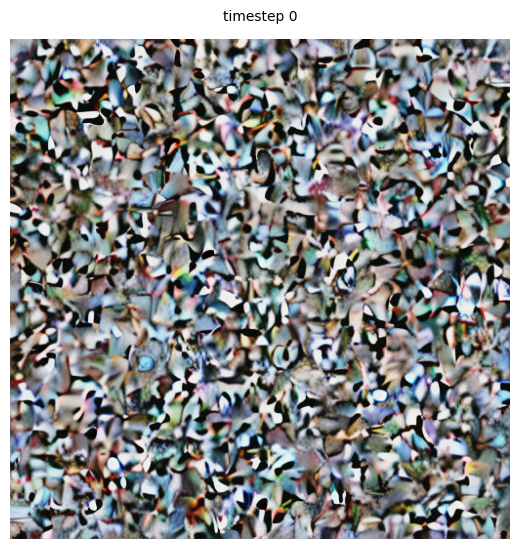

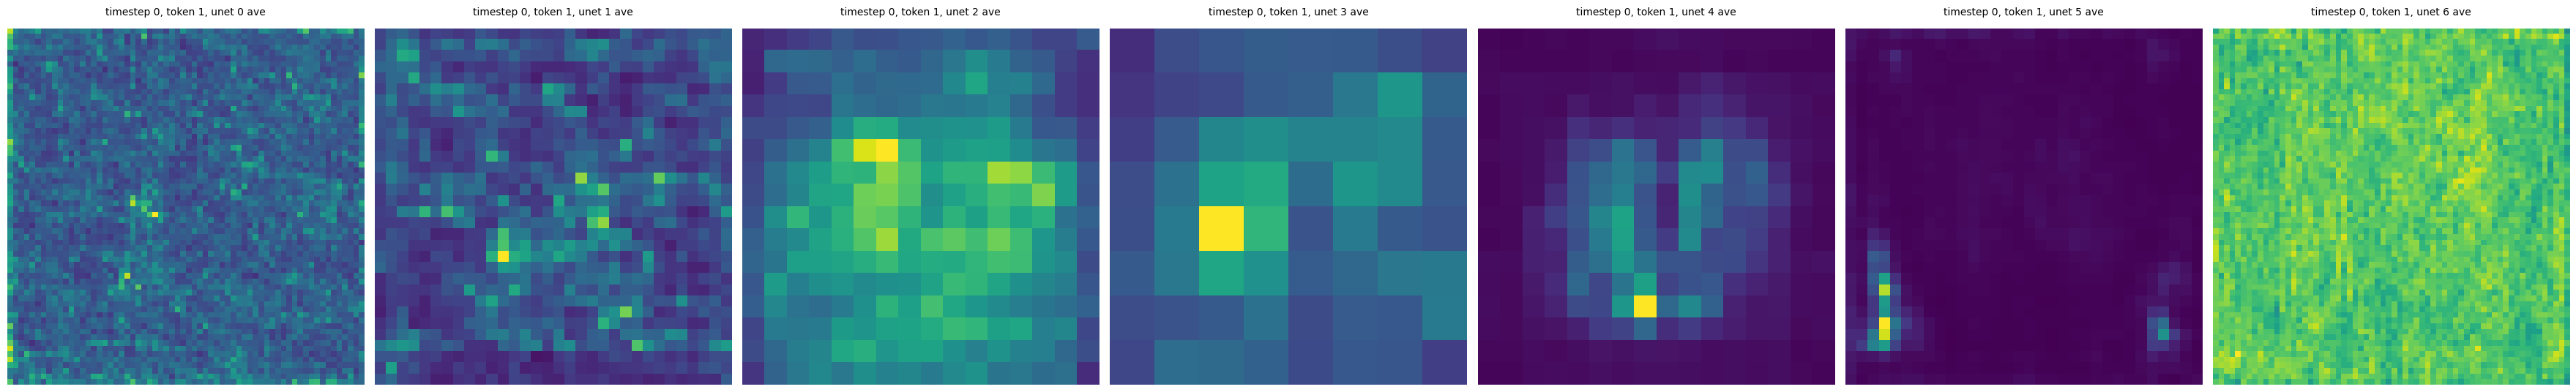

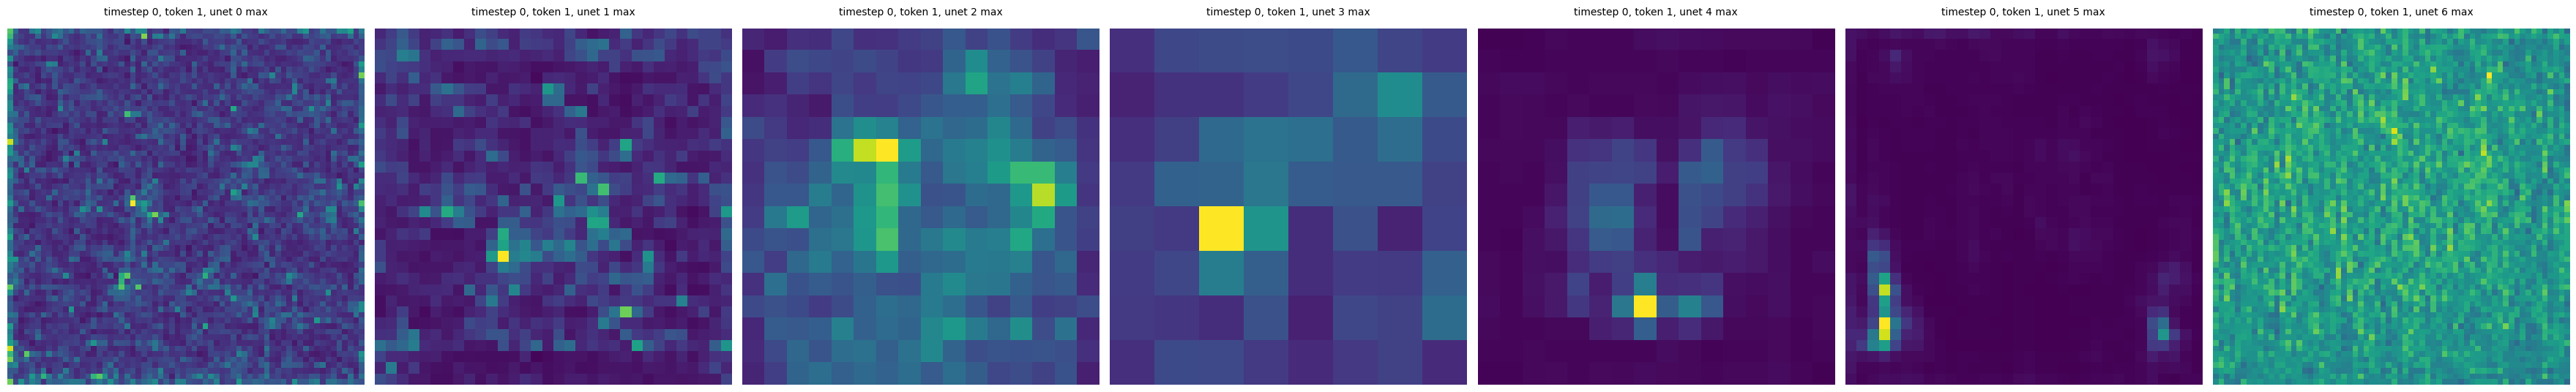

10


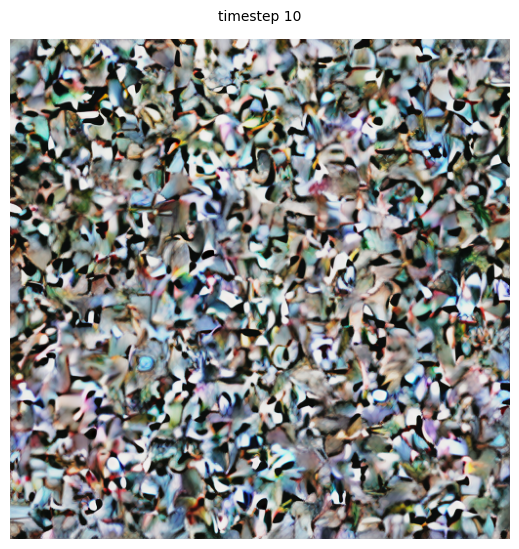

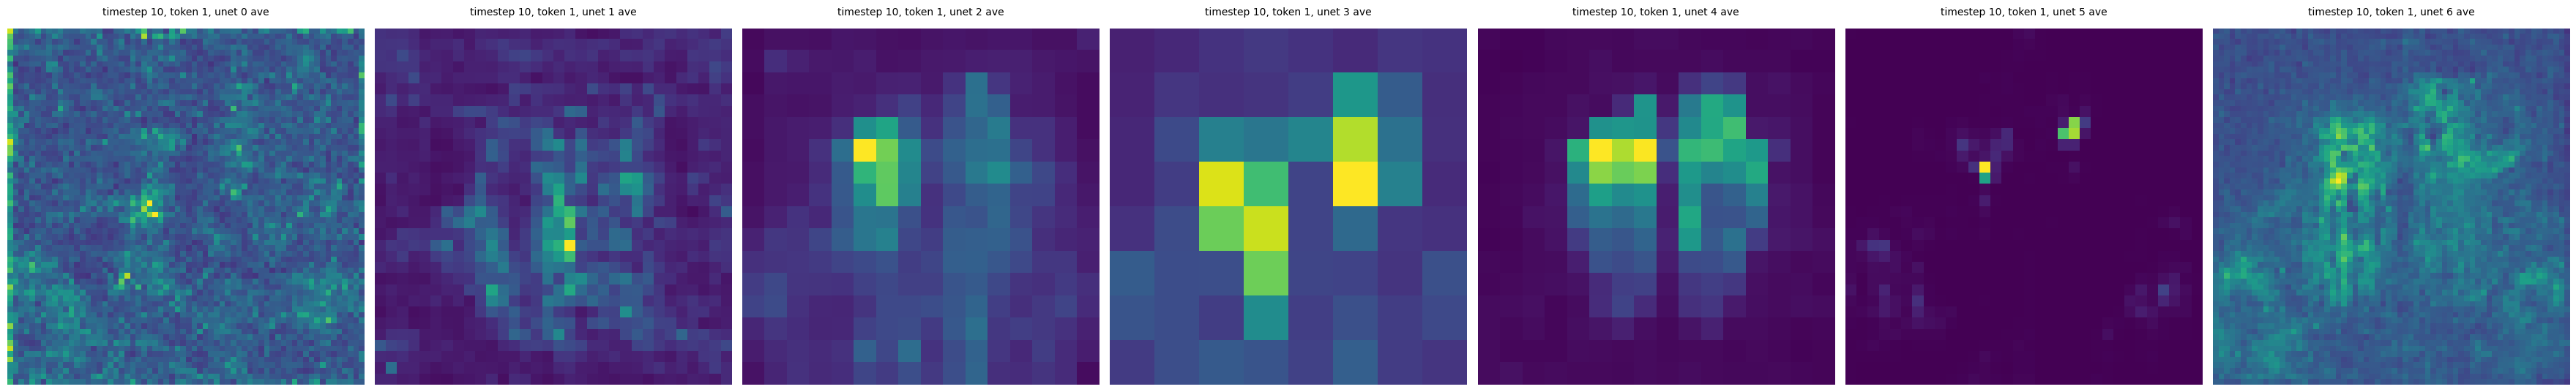

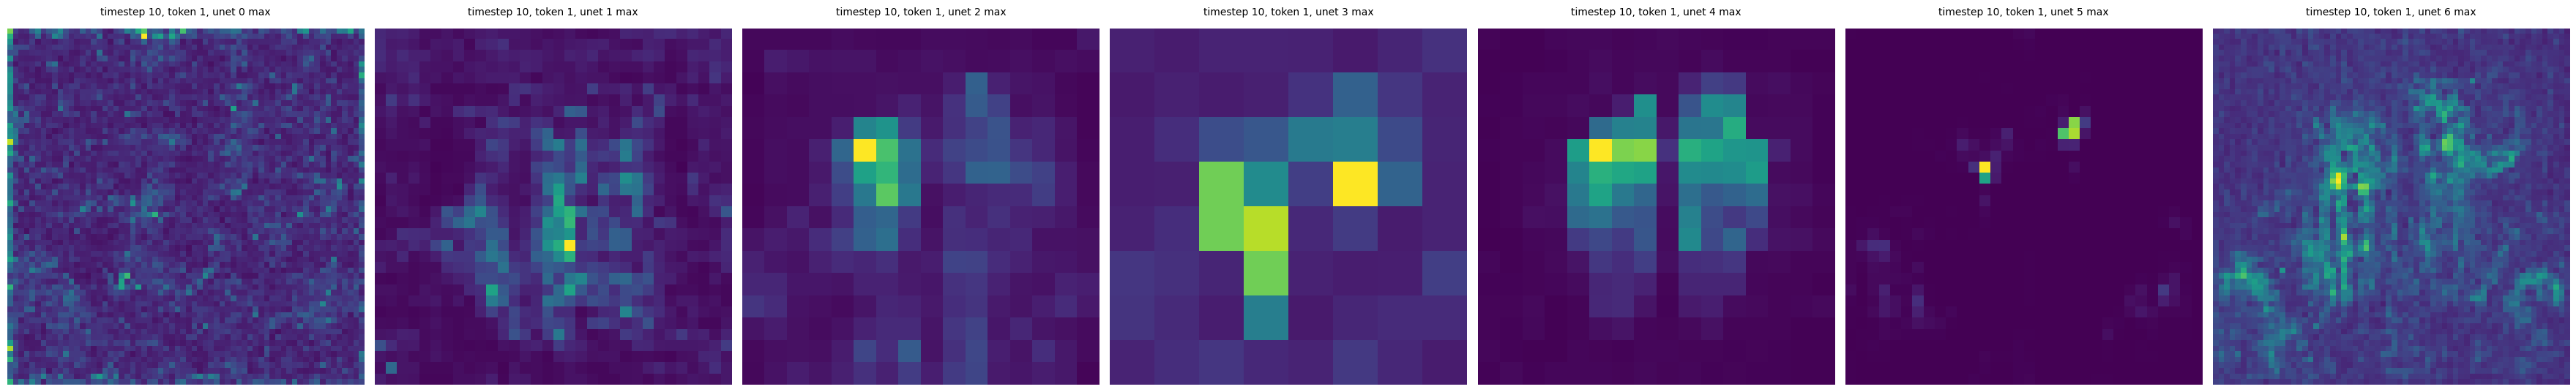

20


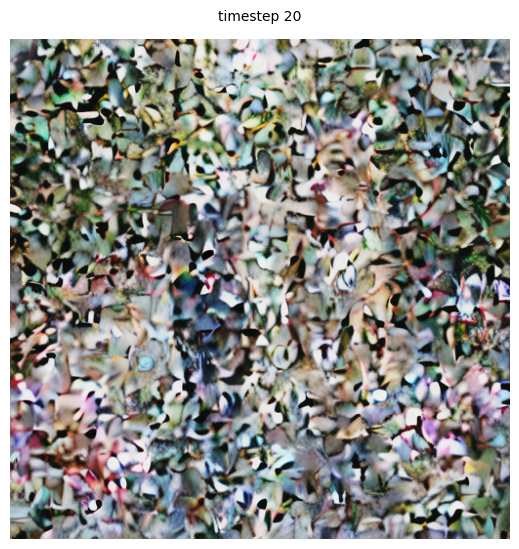

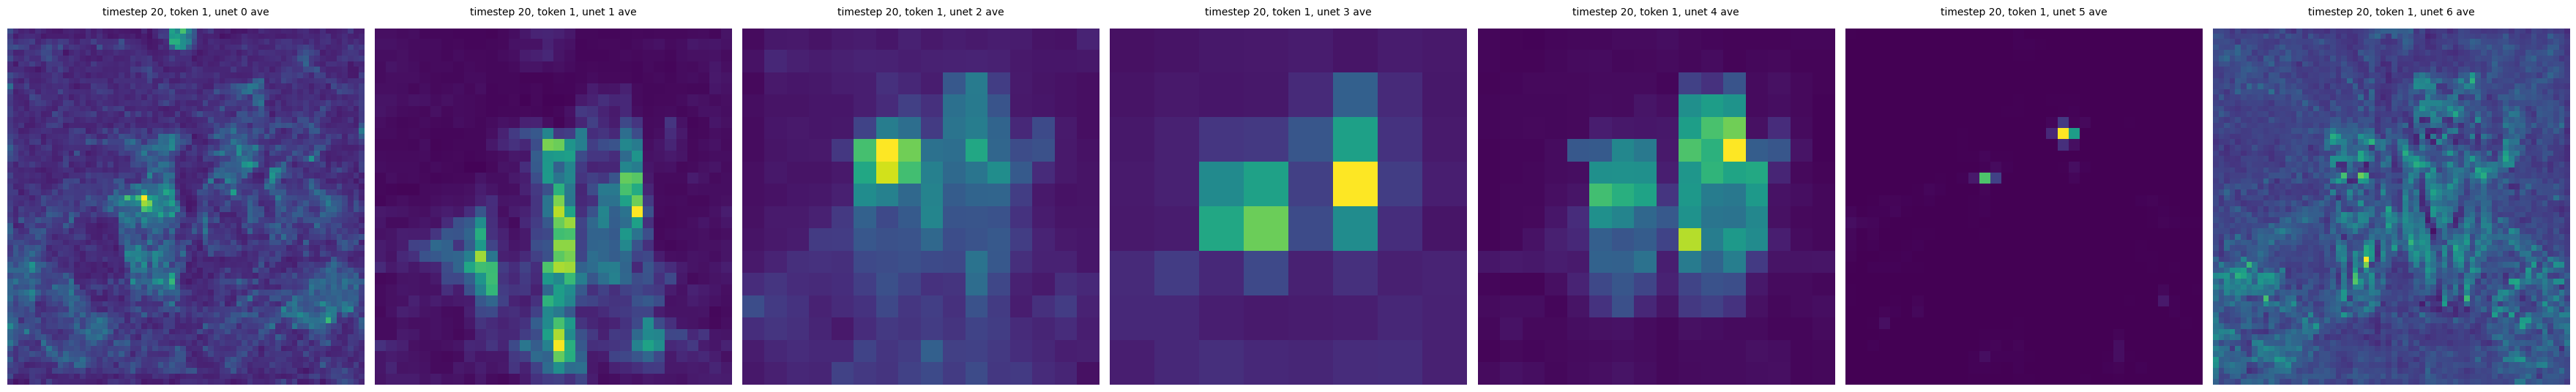

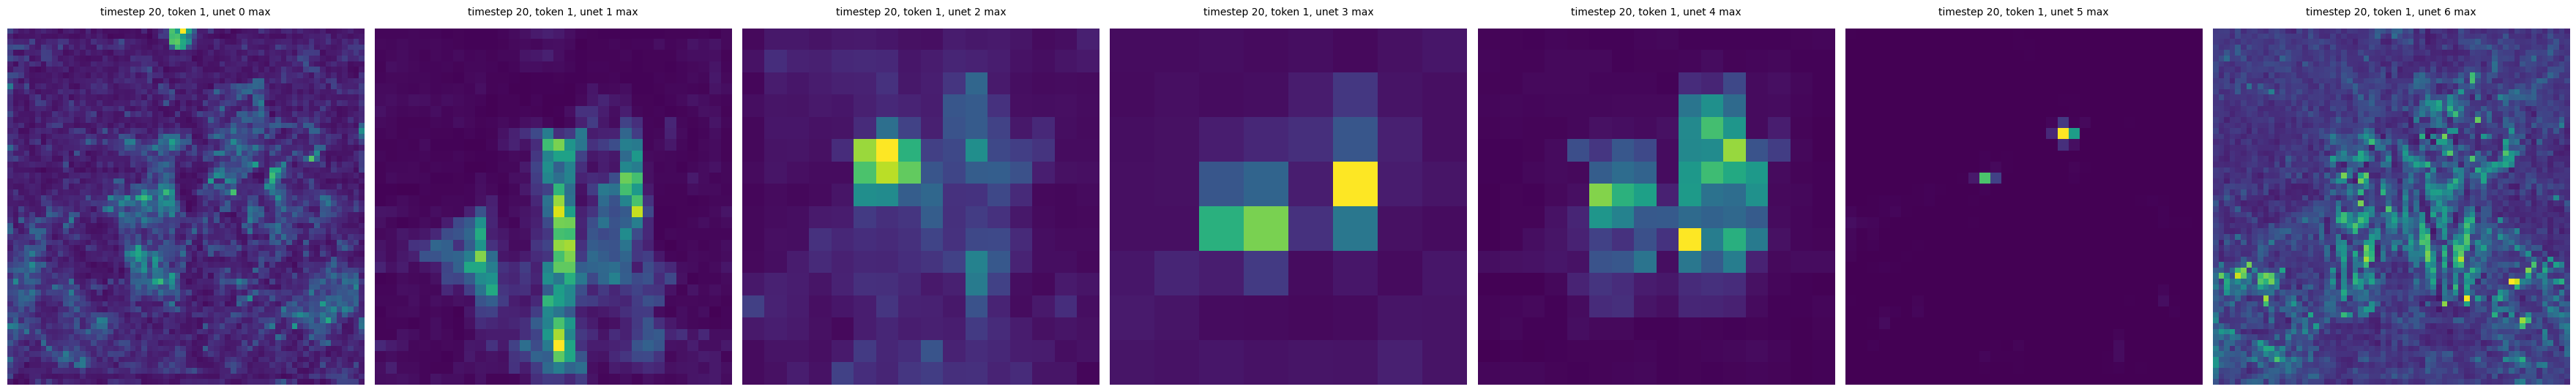

30


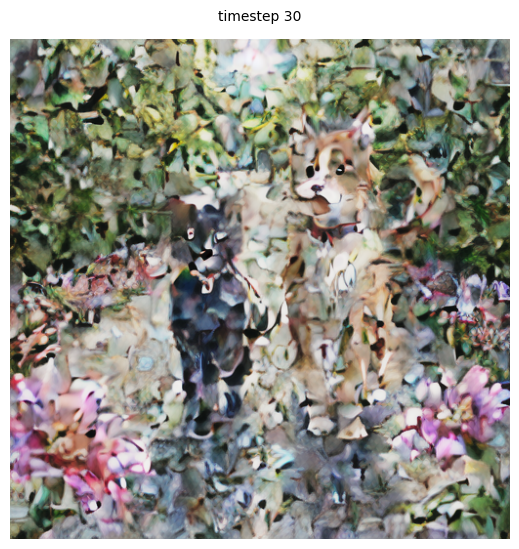

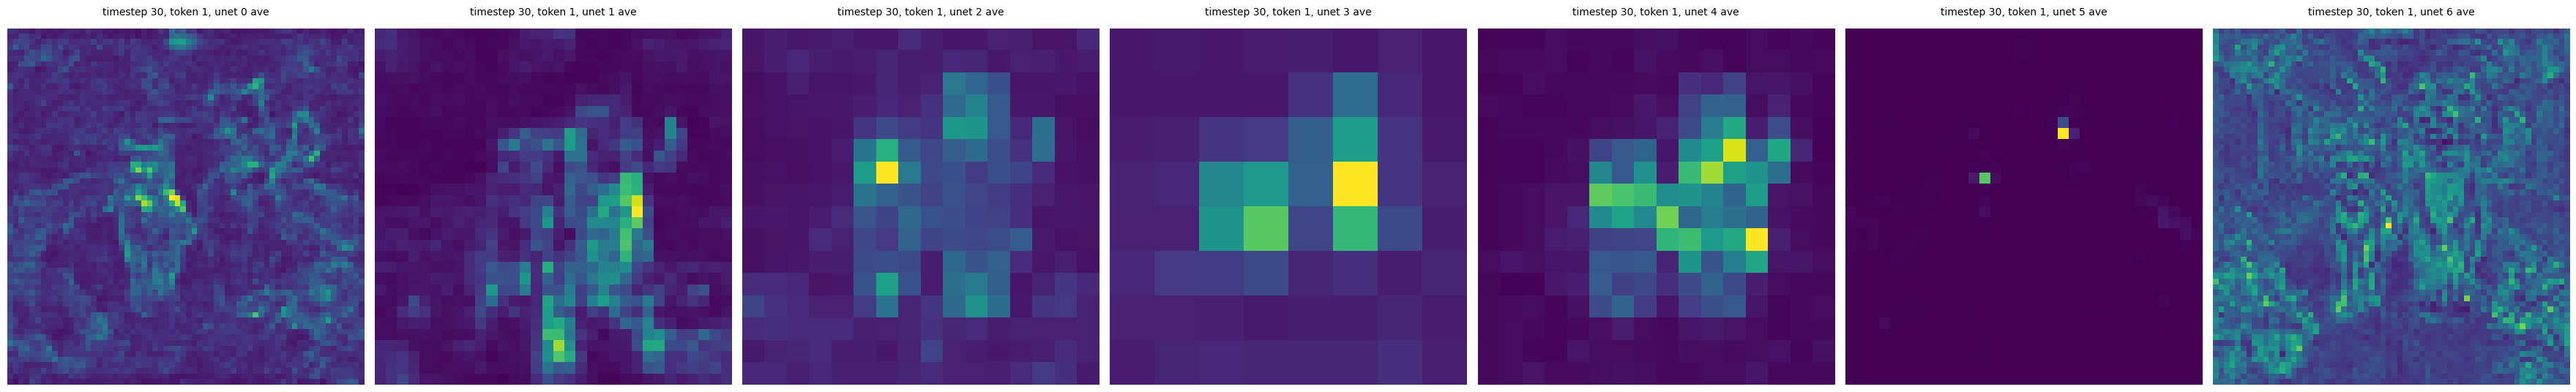

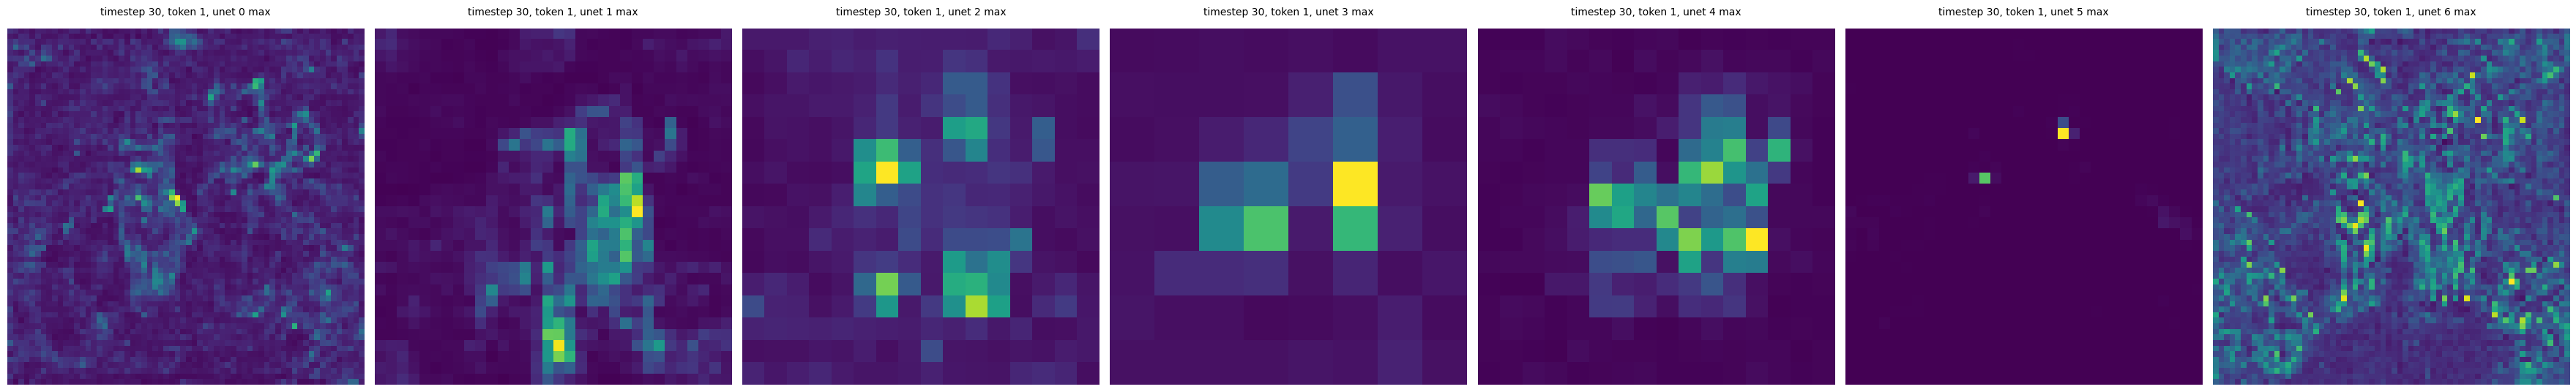

40


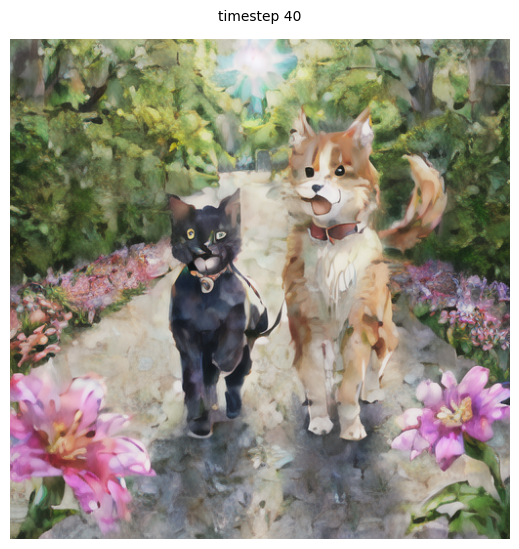

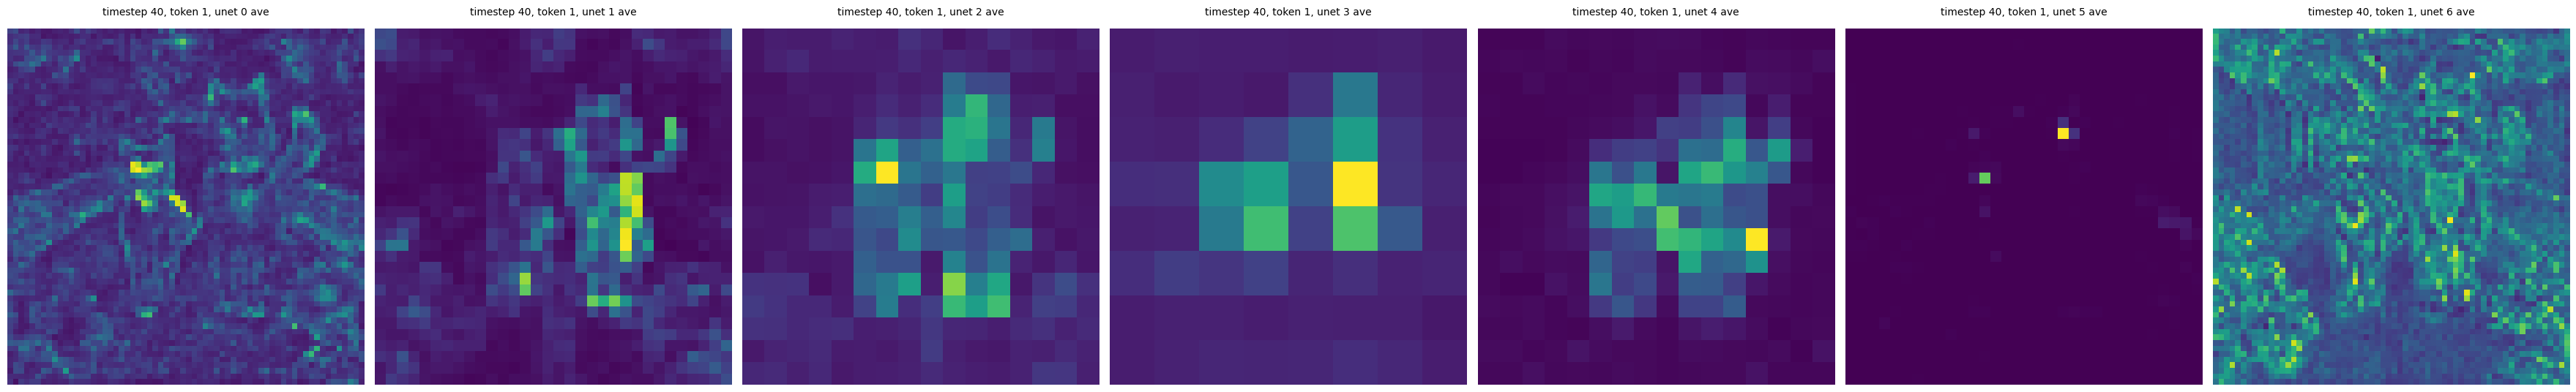

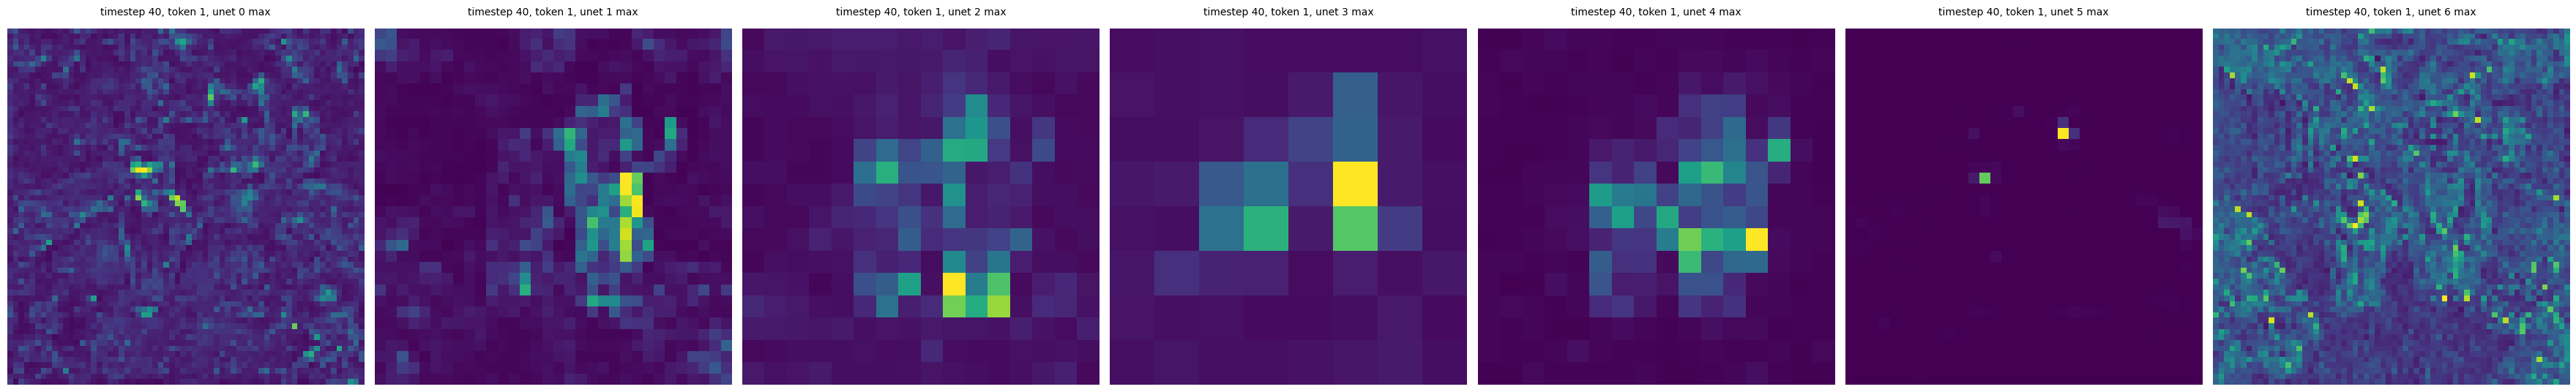

50


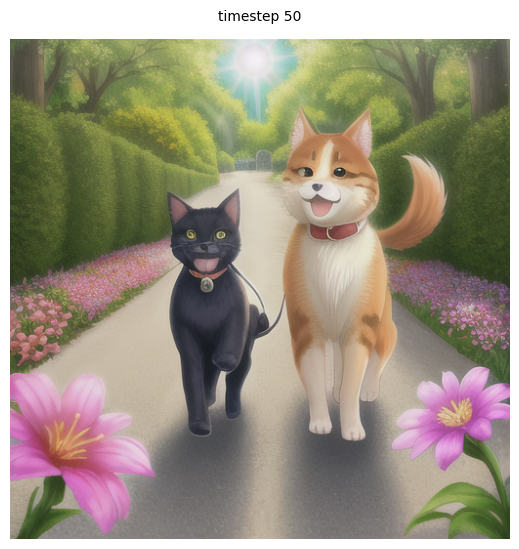

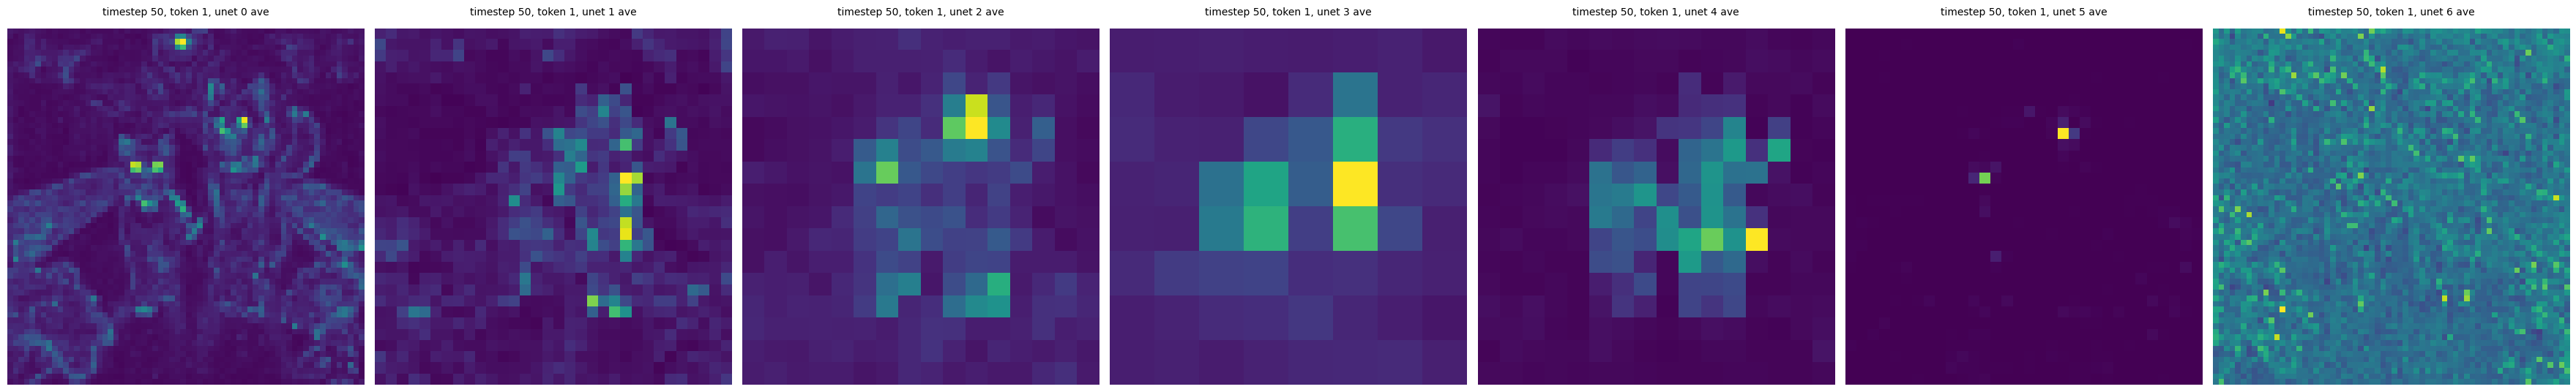

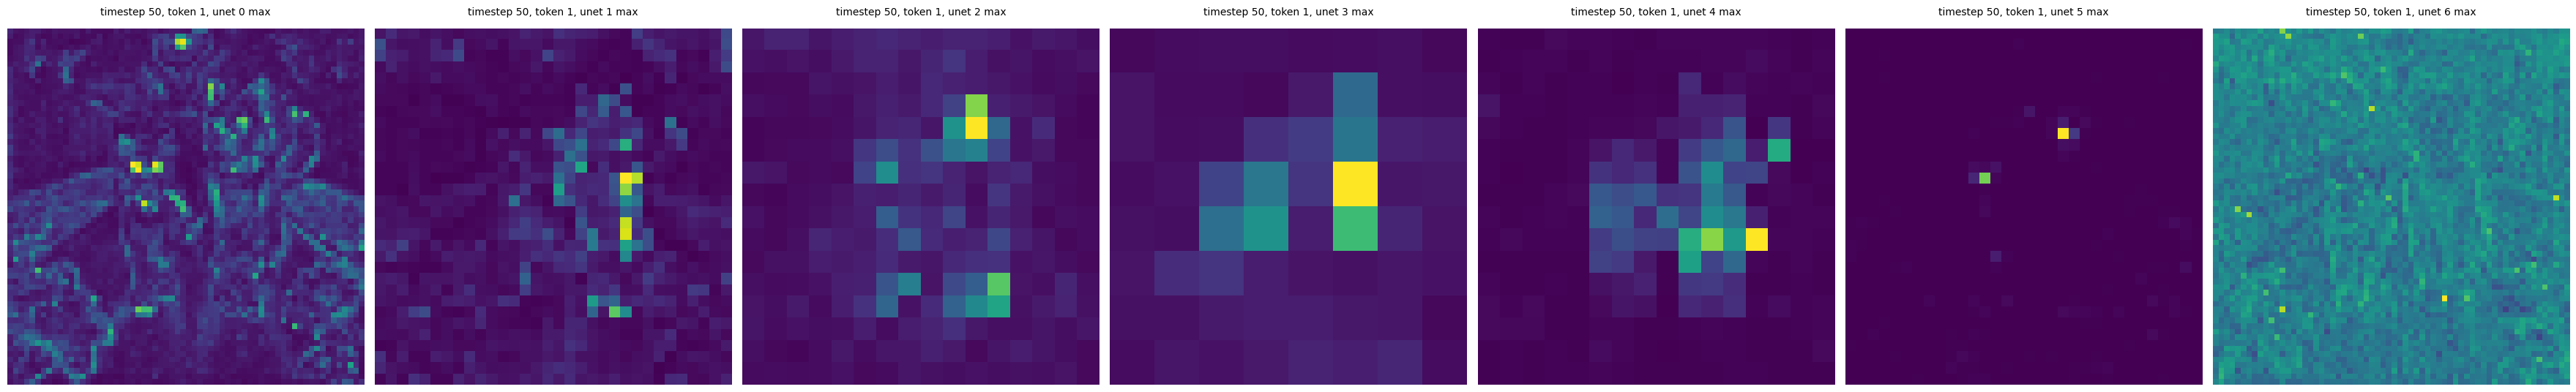

In [11]:
token = 1 # dog
for t in (0,10,20,30,40,50):
    print(t)
    show1(t,token)